In [1]:

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries loaded successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries loaded successfully!
TensorFlow version: 2.19.0


In [2]:
# ============================================
# TOY CAR DATASET LOADER (Filename-based labels)
# ============================================

class ToyCarDatasetLoader:
    """
    Loader for ToyCar dataset where labels are in filenames
    Structure: train/ and test/ folders with files containing 'normal' or 'anomaly' in name
    """

    def __init__(self, data_dir='ToyCar'):
        self.data_dir = data_dir
        self.train_dir = os.path.join(data_dir, 'train')
        self.test_dir = os.path.join(data_dir, 'test')

    def get_label_from_filename(self, filename):
        """Extract label from filename"""
        filename_lower = filename.lower()
        if 'anomaly' in filename_lower or 'anomalous' in filename_lower:
            return 1  # Anomalous
        elif 'normal' in filename_lower:
            return 0  # Normal
        else:
            return None  # Unknown

    def get_audio_files(self, directory):
        """Get all audio files from directory with their labels"""
        audio_files = []
        labels = []

        if not os.path.exists(directory):
            print(f"Directory not found: {directory}")
            return audio_files, labels

        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(('.wav', '.flac', '.mp3')):
                    filepath = os.path.join(root, file)
                    label = self.get_label_from_filename(file)
                    if label is not None:
                        audio_files.append(filepath)
                        labels.append(label)

        return sorted(audio_files), labels

    def load_dataset(self, use_train=True, use_test=True, max_samples=None, sr=16000,
                     combine_and_split=True, test_size=0.2):
        """
        Load the complete dataset

        Args:
            use_train: Load training data (only normal in train folder)
            use_test: Load test data (both normal and anomaly)
            max_samples: Limit number of samples per class
            sr: Sample rate
            combine_and_split: If True, combine train+test and split properly (recommended)
            test_size: Test split ratio if combine_and_split=True

        Returns:
            X_train, X_test, y_train, y_test, filepaths_train, filepaths_test
        """
        X_all = []
        y_all = []
        filepaths_all = []

        # Load training data
        if use_train and os.path.exists(self.train_dir):
            print("Loading training data...")
            train_files, train_labels = self.get_audio_files(self.train_dir)
            print(f"Found {len(train_files)} training files")

            normal_count = 0
            for filepath, label in zip(train_files, train_labels):
                if max_samples and label == 0 and normal_count >= max_samples:
                    continue
                try:
                    audio, _ = librosa.load(filepath, sr=sr, duration=10)
                    X_all.append(audio)
                    y_all.append(label)
                    filepaths_all.append(filepath)
                    if label == 0:
                        normal_count += 1
                except Exception as e:
                    print(f"Error loading {filepath}: {e}")
                    continue

        # Load test data
        if use_test and os.path.exists(self.test_dir):
            print("\nLoading test data...")
            test_files, test_labels = self.get_audio_files(self.test_dir)
            print(f"Found {len(test_files)} test files")

            normal_count = 0
            anomaly_count = 0
            for filepath, label in zip(test_files, test_labels):
                if max_samples:
                    if label == 0 and normal_count >= max_samples:
                        continue
                    if label == 1 and anomaly_count >= max_samples:
                        continue

                try:
                    audio, _ = librosa.load(filepath, sr=sr, duration=10)
                    X_all.append(audio)
                    y_all.append(label)
                    filepaths_all.append(filepath)
                    if label == 0:
                        normal_count += 1
                    else:
                        anomaly_count += 1
                except Exception as e:
                    print(f"Error loading {filepath}: {e}")
                    continue

        # Combine and split properly if requested
        if combine_and_split:
            print("\nCombining train and test data, then splitting properly...")
            X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
                X_all, y_all, filepaths_all,
                test_size=test_size,
                random_state=42,
                stratify=y_all  # Ensures both classes in train and test
            )
        else:
            # Use original train/test split
            X_train = X_all[:len([x for x in y_all if x == 0])]  # Only normal from train
            y_train = y_all[:len([x for x in y_all if x == 0])]
            paths_train = filepaths_all[:len([x for x in y_all if x == 0])]

            X_test = X_all[len([x for x in y_all if x == 0]):]  # Test data
            y_test = y_all[len([x for x in y_all if x == 0]):]
            paths_test = filepaths_all[len([x for x in y_all if x == 0]):]

        # Summary
        print("\n" + "=" * 60)
        print("DATASET SUMMARY")
        print("=" * 60)
        print(f"Training set: {len(X_train)} samples")
        if len(X_train) > 0:
            train_normal = sum(1 for y in y_train if y == 0)
            train_anomaly = sum(1 for y in y_train if y == 1)
            print(f"  Normal: {train_normal}, Anomalous: {train_anomaly}")

        print(f"\nTest set: {len(X_test)} samples")
        if len(X_test) > 0:
            test_normal = sum(1 for y in y_test if y == 0)
            test_anomaly = sum(1 for y in y_test if y == 1)
            print(f"  Normal: {test_normal}, Anomalous: {test_anomaly}")
        print("=" * 60)

        return (X_train, X_test, np.array(y_train), np.array(y_test),
                paths_train, paths_test)

# Initialize loader
loader = ToyCarDatasetLoader(data_dir='/content/drive/MyDrive/ToyCar')

# Test loading - IMPORTANT: combine_and_split=True ensures both classes in training
print("Testing dataset loader...")
X_train, X_test, y_train, y_test, paths_train, paths_test = loader.load_dataset(
    use_train=True,
    use_test=True,
    max_samples=500,  # Limit for quick testing, remove for full dataset
    sr=16000,
    combine_and_split=True,  # CRITICAL: This ensures training has both normal and anomalous
    test_size=0.2
)

Testing dataset loader...
Loading training data...
Found 1000 training files

Loading test data...
Found 200 test files

Combining train and test data, then splitting properly...

DATASET SUMMARY
Training set: 560 samples
  Normal: 480, Anomalous: 80

Test set: 140 samples
  Normal: 120, Anomalous: 20


In [3]:
# ============================================
# FEATURE EXTRACTION
# ============================================

def extract_mfcc_features(audio, sr=16000, n_mfcc=13):
    """Extract MFCC features"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # Average over time
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def extract_melspectrogram(audio, sr=16000, n_mels=128, hop_length=512):
    """Extract mel-spectrogram"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def extract_multiple_features(audio, sr=16000):
    """Extract multiple audio features"""
    features = {}

    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    features['mfcc_mean'] = np.mean(mfcc, axis=1)
    features['mfcc_std'] = np.std(mfcc, axis=1)

    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    features['zcr_mean'] = np.mean(zero_crossing_rate)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma, axis=1)

    # Combine all features
    feature_vector = np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        [features['spectral_centroid_mean']],
        [features['spectral_rolloff_mean']],
        [features['zcr_mean']],
        features['chroma_mean']
    ])

    return feature_vector

def prepare_features(X_audio, feature_type='mfcc', sr=16000):
    """
    Extract features from audio data

    feature_type: 'mfcc', 'melspectrogram', or 'multiple'
    """
    X_features = []

    print(f"Extracting {feature_type} features...")
    for i, audio in enumerate(X_audio):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(X_audio)} samples")

        if feature_type == 'mfcc':
            features = extract_mfcc_features(audio, sr=sr)
        elif feature_type == 'melspectrogram':
            features = extract_melspectrogram(audio, sr=sr)
            # Flatten for traditional ML, or keep 2D for CNN
            features = features.flatten()
        elif feature_type == 'multiple':
            features = extract_multiple_features(audio, sr=sr)
        else:
            raise ValueError(f"Unknown feature type: {feature_type}")

        X_features.append(features)

    return np.array(X_features)

In [4]:
# ============================================
# FEATURE EXTRACTION
# ============================================

def extract_mfcc_features(audio, sr=16000, n_mfcc=13):
    """Extract MFCC features"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # Average over time
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def extract_melspectrogram(audio, sr=16000, n_mels=128, hop_length=512):
    """Extract mel-spectrogram"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def extract_multiple_features(audio, sr=16000):
    """Extract multiple audio features"""
    features = {}

    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    features['mfcc_mean'] = np.mean(mfcc, axis=1)
    features['mfcc_std'] = np.std(mfcc, axis=1)

    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    features['zcr_mean'] = np.mean(zero_crossing_rate)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma, axis=1)

    # Combine all features
    feature_vector = np.concatenate([
        features['mfcc_mean'],
        features['mfcc_std'],
        [features['spectral_centroid_mean']],
        [features['spectral_rolloff_mean']],
        [features['zcr_mean']],
        features['chroma_mean']
    ])

    return feature_vector

def prepare_features(X_audio, feature_type='mfcc', sr=16000):
    """
    Extract features from audio data

    feature_type: 'mfcc', 'melspectrogram', or 'multiple'
    """
    X_features = []

    print(f"Extracting {feature_type} features...")
    for i, audio in enumerate(X_audio):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(X_audio)} samples")

        if feature_type == 'mfcc':
            features = extract_mfcc_features(audio, sr=sr)
        elif feature_type == 'melspectrogram':
            features = extract_melspectrogram(audio, sr=sr)
            # Flatten for traditional ML, or keep 2D for CNN
            features = features.flatten()
        elif feature_type == 'multiple':
            features = extract_multiple_features(audio, sr=sr)
        else:
            raise ValueError(f"Unknown feature type: {feature_type}")

        X_features.append(features)

    return np.array(X_features)

# ============================================
# MODEL ARCHITECTURES (IMPROVED)
# ============================================

def build_mlp_classifier(input_dim, num_classes=2):
    """Build an improved MLP with better regularization"""
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # Increased dropout

        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def get_class_weights(y_train):
    """Calculate class weights to handle imbalance"""
    from collections import Counter
    class_counts = Counter(y_train)
    total = len(y_train)

    # Calculate weights: more weight to minority class
    weight_for_0 = total / (2.0 * class_counts[0])
    weight_for_1 = total / (2.0 * class_counts[1])

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print(f"Class weights: {class_weight}")
    print(f"  Normal (0): {class_counts[0]} samples, weight: {weight_for_0:.3f}")
    print(f"  Anomalous (1): {class_counts[1]} samples, weight: {weight_for_1:.3f}")

    return class_weight

In [5]:
# ============================================
# COMPLETE TRAINING PIPELINE (IMPROVED)
# ============================================

def train_model_improved(X_train, X_test, y_train, y_test,
                        feature_type='multiple', epochs=100, batch_size=32):
    """
    Improved training pipeline with:
    - Better features
    - Class weights
    - Better regularization
    - Early stopping on validation loss
    """
    print("=" * 60)
    print("IMPROVED TRAINING PIPELINE")
    print("=" * 60)

    # Step 1: Extract features
    print("\nStep 1: Extracting features...")
    X_train_features = prepare_features(X_train, feature_type=feature_type)
    X_test_features = prepare_features(X_test, feature_type=feature_type)

    print(f"Train features shape: {X_train_features.shape}")
    print(f"Test features shape: {X_test_features.shape}")

    # Step 2: Normalize
    print("\nStep 2: Normalizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_test_scaled = scaler.transform(X_test_features)

    # Step 3: Calculate class weights
    print("\nStep 3: Calculating class weights...")
    class_weights = get_class_weights(y_train)

    # Step 4: Build model
    print("\nStep 4: Building model...")
    model = build_mlp_classifier(input_dim=X_train_scaled.shape[1])
    model.summary()

    # Step 5: Setup callbacks
    print("\nStep 5: Setting up callbacks...")
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Step 6: Train
    print("\nStep 6: Training model...")
    print("=" * 60)
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,  # IMPORTANT: Use class weights
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Step 7: Evaluate
    print("\n" + "=" * 60)
    print("Step 7: Evaluating model...")
    print("=" * 60)

    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=['Normal', 'Anomalous']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # ROC AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Plot training history
    plot_training_history(history)

    return model, history, scaler, y_pred, y_pred_proba

def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Verify the loader
if X_train is not None and len(X_train) > 0:
    print(f"\n✓ Successfully loaded dataset!")
    print(f"  Train samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")

    # Check if training has both classes
    train_normal = sum(1 for y in y_train if y == 0)
    train_anomaly = sum(1 for y in y_train if y == 1)

    if train_anomaly == 0:
        print("\n⚠ WARNING: Training set has NO anomalous samples!")
        print("   The model won't learn to detect anomalies.")
        print("   Make sure combine_and_split=True in load_dataset()")
    else:
        print(f"\n✓ Training set has both classes:")
        print(f"   Normal: {train_normal}, Anomalous: {train_anomaly}")
else:
    print("⚠ Dataset not loaded. Check the path and structure.")


✓ Successfully loaded dataset!
  Train samples: 560
  Test samples: 140

✓ Training set has both classes:
   Normal: 480, Anomalous: 80


Starting improved training...
IMPROVED TRAINING PIPELINE

Step 1: Extracting features...
Extracting multiple features...
  Processed 100/560 samples
  Processed 200/560 samples
  Processed 300/560 samples
  Processed 400/560 samples
  Processed 500/560 samples
Extracting multiple features...
  Processed 100/140 samples
Train features shape: (560, 41)
Test features shape: (140, 41)

Step 2: Normalizing features...

Step 3: Calculating class weights...
Class weights: {0: 0.5833333333333334, 1: 3.5}
  Normal (0): 480 samples, weight: 0.583
  Anomalous (1): 80 samples, weight: 3.500

Step 4: Building model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,570 (209.26 KB)

 Trainable params: 52,802 (206.26 KB)

 Non-trainable params: 768 (3.00 KB)


Step 5: Setting up callbacks...

Step 6: Training model...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.2758 - loss: 1.7129 - val_accuracy: 0.1929 - val_loss: 1.2118 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2948 - loss: 1.6873 - val_accuracy: 0.2571 - val_loss: 1.1652 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2952 - loss: 1.6626 - val_accuracy: 0.3214 - val_loss: 1.1278 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3456 - loss: 1.4878 - val_accuracy: 0.4000 - val_loss: 1.0957 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3915 - loss: 1.3813 - val_accuracy: 0.5071 - val_loss: 1.0710 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3580 - loss: 1.4982 - val_accuracy: 0.5643 - val_loss: 1.0511 - learning_rate: 1.0000e-04
Epoch 7

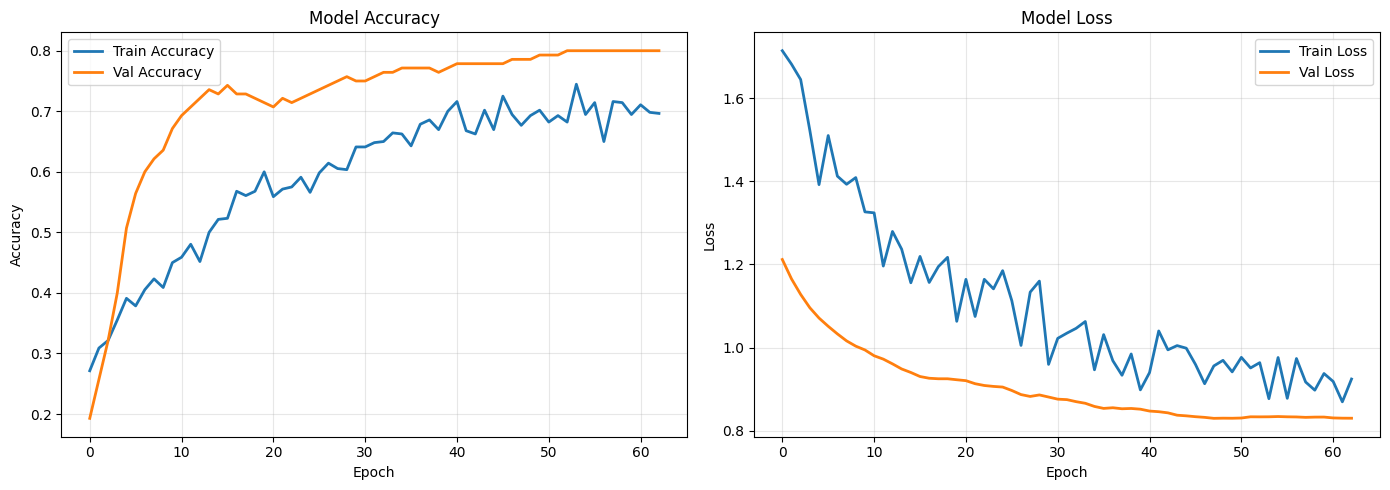

OSError: [Errno 95] Operation not supported: '/content/drive/Mydrive'

In [6]:
# ============================================
# RUN IMPROVED TRAINING
# ============================================

# Make sure data is loaded and has both classes
if X_train is not None and len(X_train) > 0:
    train_anomaly = sum(1 for y in y_train if y == 1)

    if train_anomaly > 0:
        print("Starting improved training...")
        print("=" * 60)

        # Train with improved pipeline
        model, history, scaler, y_pred, y_pred_proba = train_model_improved(
            X_train, X_test, y_train, y_test,
            feature_type='multiple',  # Use multiple features for better performance
            epochs=100,
            batch_size=32
        )

        # Save model
        model.save('/content/drive/Mydrive/toycar_anomaly_detector_improved.h5')
        print("\n✓ Model saved as 'toycar_anomaly_detector_improved.h5'")

    else:
        print("\n⚠ Cannot train: Training set has no anomalous samples!")
        print("Please reload data with combine_and_split=True")
else:
    print("⚠ Data not loaded. Please run the data loading cell first.")


In [7]:
model.save('/content/drive/MyDrive/toycar_anomaly_detector_improved.h5')

In [8]:
# ============================================
# INFERENCE CODE - PREDICT ON NEW AUDIO FILES
# ============================================

class AnomalyDetector:
    """
    Inference class for anomaly detection on new audio files
    """

    def __init__(self, model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5',
                 scaler=None, feature_type='multiple', sr=16000):
        """
        Initialize the detector

        Args:
            model_path: Path to saved model file
            scaler: Pre-fitted StandardScaler (if None, will try to load from training)
            feature_type: Type of features to extract ('mfcc', 'melspectrogram', 'multiple')
            sr: Sample rate for audio loading
        """
        self.model_path = model_path
        self.scaler = scaler
        self.feature_type = feature_type
        self.sr = sr

        # Load model
        print(f"Loading model from {model_path}...")
        try:
            self.model = keras.models.load_model(model_path)
            print("✓ Model loaded successfully!")
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            self.model = None

    def preprocess_audio(self, audio_file):
        """
        Load and preprocess a single audio file

        Args:
            audio_file: Path to audio file or audio array

        Returns:
            Preprocessed audio array
        """
        if isinstance(audio_file, str):
            # Load from file
            if not os.path.exists(audio_file):
                raise FileNotFoundError(f"Audio file not found: {audio_file}")
            audio, _ = librosa.load(audio_file, sr=self.sr, duration=10)
        else:
            # Assume it's already an audio array
            audio = audio_file

        return audio

    def extract_features_single(self, audio):
        """
        Extract features from a single audio sample
        """
        if self.feature_type == 'mfcc':
            features = extract_mfcc_features(audio, sr=self.sr)
        elif self.feature_type == 'melspectrogram':
            features = extract_melspectrogram(audio, sr=self.sr)
            features = features.flatten()
        elif self.feature_type == 'multiple':
            features = extract_multiple_features(audio, sr=self.sr)
        else:
            raise ValueError(f"Unknown feature type: {self.feature_type}")

        return features

    def predict_single(self, audio_file, return_proba=False):
        """
        Predict on a single audio file

        Args:
            audio_file: Path to audio file or audio array
            return_proba: If True, return probabilities; if False, return class

        Returns:
            Prediction (0=Normal, 1=Anomalous) or probabilities
        """
        if self.model is None:
            raise ValueError("Model not loaded!")

        # Preprocess
        audio = self.preprocess_audio(audio_file)

        # Extract features
        features = self.extract_features_single(audio)
        features = features.reshape(1, -1)  # Add batch dimension

        # Normalize (if scaler available)
        if self.scaler is not None:
            features = self.scaler.transform(features)
        else:
            print("⚠ Warning: No scaler provided. Features not normalized.")

        # Predict
        proba = self.model.predict(features, verbose=0)[0]
        prediction = np.argmax(proba)

        if return_proba:
            return {
                'prediction': prediction,
                'class': 'Anomalous' if prediction == 1 else 'Normal',
                'probability_normal': float(proba[0]),
                'probability_anomalous': float(proba[1]),
                'confidence': float(max(proba))
            }
        else:
            return prediction

    def predict_batch(self, audio_files, return_proba=False):
        """
        Predict on multiple audio files

        Args:
            audio_files: List of audio file paths or arrays
            return_proba: If True, return probabilities; if False, return classes

        Returns:
            List of predictions or dictionaries with probabilities
        """
        results = []

        print(f"Processing {len(audio_files)} audio files...")
        for i, audio_file in enumerate(audio_files):
            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{len(audio_files)} files")

            try:
                result = self.predict_single(audio_file, return_proba=return_proba)
                results.append(result)
            except Exception as e:
                print(f"  Error processing {audio_file}: {e}")
                results.append(None)

        return results

    def predict_from_directory(self, directory, return_proba=False):
        """
        Predict on all audio files in a directory

        Args:
            directory: Path to directory containing audio files
            return_proba: If True, return probabilities; if False, return classes

        Returns:
            Dictionary mapping filenames to predictions
        """
        # Find all audio files
        audio_files = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(('.wav', '.flac', '.mp3')):
                    audio_files.append(os.path.join(root, file))

        print(f"Found {len(audio_files)} audio files in {directory}")

        # Predict
        results = self.predict_batch(audio_files, return_proba=return_proba)

        # Create dictionary mapping
        predictions_dict = {}
        for filepath, result in zip(audio_files, results):
            filename = os.path.basename(filepath)
            predictions_dict[filename] = result

        return predictions_dict

# ============================================
# HELPER FUNCTIONS FOR INFERENCE
# ============================================

def load_detector(model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5',
                  scaler=None, feature_type='multiple'):
    """
    Convenience function to load detector

    Args:
        model_path: Path to saved model
        scaler: Pre-fitted scaler (from training)
        feature_type: Feature type used during training

    Returns:
        AnomalyDetector instance
    """
    detector = AnomalyDetector(
        model_path=model_path,
        scaler=scaler,
        feature_type=feature_type
    )
    return detector

def print_prediction_result(result, filename=None):
    """
    Pretty print prediction result
    """
    if filename:
        print(f"\nFile: {filename}")
    print("-" * 40)

    if isinstance(result, dict):
        print(f"Prediction: {result['class']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"  Normal: {result['probability_normal']:.2%}")
        print(f"  Anomalous: {result['probability_anomalous']:.2%}")
    else:
        class_name = 'Anomalous' if result == 1 else 'Normal'
        print(f"Prediction: {class_name}")

print("✓ Inference code loaded!")
print("\nUsage example:")
print("  detector = load_detector(model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5', scaler=scaler)")
print("  result = detector.predict_single('/content/drive/MyDrive/ToyCar/test/section_00_source_test_anomaly_0001_car_B1_spd_31V_mic_1.wav', return_proba=True)")
print("  print_prediction_result(result)")


✓ Inference code loaded!

Usage example:
  detector = load_detector(model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5', scaler=scaler)
  result = detector.predict_single('/content/drive/MyDrive/ToyCar/test/section_00_source_test_anomaly_0001_car_B1_spd_31V_mic_1.wav', return_proba=True)
  print_prediction_result(result)


In [9]:
# ============================================
# EXAMPLE: USE THE TRAINED MODEL FOR INFERENCE
# ============================================

# Example 1: Load detector (use scaler from training if available)
if 'scaler' in globals() and scaler is not None:
    print("Loading detector with trained scaler...")
    detector = load_detector(
        model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5',
        scaler=scaler,
        feature_type='multiple'
    )
else:
    print("Loading detector without scaler (will use raw features)...")
    print("⚠ Note: For best results, use the scaler from training")
    detector = load_detector(
        model_path='/content/drive/MyDrive/toycar_anomaly_detector_improved.h5',
        scaler=None,
        feature_type='multiple'
    )

# Example 2: Predict on a single test file
if len(paths_test) > 0:
    print("\n" + "=" * 60)
    print("Example: Predicting on a test file")
    print("=" * 60)

    # Pick a test file
    test_file = paths_test[0]
    true_label = y_test[0]
    true_class = 'Anomalous' if true_label == 1 else 'Normal'

    print(f"\nTest file: {os.path.basename(test_file)}")
    print(f"True label: {true_class}")

    # Predict
    result = detector.predict_single(test_file, return_proba=True)
    print_prediction_result(result)

    # Check if correct
    if result['prediction'] == true_label:
        print("\n✓ Prediction is CORRECT!")
    else:
        print("\n✗ Prediction is INCORRECT")
else:
    print("No test files available for example prediction")


Loading detector with trained scaler...
Loading model from /content/drive/MyDrive/toycar_anomaly_detector_improved.h5...
✓ Model loaded successfully!

Example: Predicting on a test file

Test file: section_00_source_test_normal_0003_car_B2_spd_31V_mic_1.wav
True label: Anomalous
----------------------------------------
Prediction: Normal
Confidence: 67.27%
  Normal: 67.27%
  Anomalous: 32.73%

✗ Prediction is INCORRECT


In [10]:
# ============================================
# IMPROVE PREDICTIONS - CONFIDENCE THRESHOLD
# ============================================

def predict_with_threshold(detector, audio_file, threshold=0.7):
    """
    Predict with confidence threshold - if confidence is too low, mark as 'Uncertain'

    Args:
        detector: AnomalyDetector instance
        audio_file: Path to audio file
        threshold: Minimum confidence threshold (0-1)

    Returns:
        Prediction result with uncertainty handling
    """
    result = detector.predict_single(audio_file, return_proba=True)

    if result['confidence'] < threshold:
        result['class'] = 'Uncertain'
        result['uncertain'] = True
    else:
        result['uncertain'] = False

    return result

# Example: Use threshold to flag uncertain predictions
if 'detector' in globals() and len(paths_test) > 0:
    print("=" * 60)
    print("PREDICTIONS WITH CONFIDENCE THRESHOLD")
    print("=" * 60)

    threshold = 0.7  # Only trust predictions with >70% confidence

    print(f"\nUsing confidence threshold: {threshold:.0%}")
    print("Predictions below this threshold will be marked as 'Uncertain'\n")

    # Test on a few files
    for i in range(min(5, len(paths_test))):
        test_file = paths_test[i]
        true_label = y_test[i]
        true_class = 'Anomalous' if true_label == 1 else 'Normal'

        result = predict_with_threshold(detector, test_file, threshold=threshold)

        print(f"{i+1}. {os.path.basename(test_file)[:50]}")
        print(f"   True: {true_class:8s} | Pred: {result['class']:8s} | Conf: {result['confidence']:.2%}")

        if result['uncertain']:
            print(f"   ⚠ Low confidence - prediction may be unreliable")
        print()
else:
    print("Detector or test data not available.")


PREDICTIONS WITH CONFIDENCE THRESHOLD

Using confidence threshold: 70%
Predictions below this threshold will be marked as 'Uncertain'

1. section_00_source_test_normal_0003_car_B2_spd_31V_
   True: Anomalous | Pred: Uncertain | Conf: 67.27%
   ⚠ Low confidence - prediction may be unreliable

2. section_00_source_train_normal_0274_car_B1_spd_40V
   True: Normal   | Pred: Anomalous | Conf: 83.08%

3. section_00_source_train_normal_0099_car_B2_spd_31V
   True: Normal   | Pred: Uncertain | Conf: 62.48%
   ⚠ Low confidence - prediction may be unreliable

4. section_00_source_train_normal_0053_car_B1_spd_31V
   True: Normal   | Pred: Normal   | Conf: 74.76%

5. section_00_source_test_anomaly_0005_car_B1_spd_31V
   True: Anomalous | Pred: Uncertain | Conf: 61.51%
   ⚠ Low confidence - prediction may be unreliable



Processing 100 audio files...
  Processed 10/100 files
  Processed 20/100 files
  Processed 30/100 files
  Processed 40/100 files
  Processed 50/100 files
  Processed 60/100 files
  Processed 70/100 files
  Processed 80/100 files
  Processed 90/100 files
  Processed 100/100 files


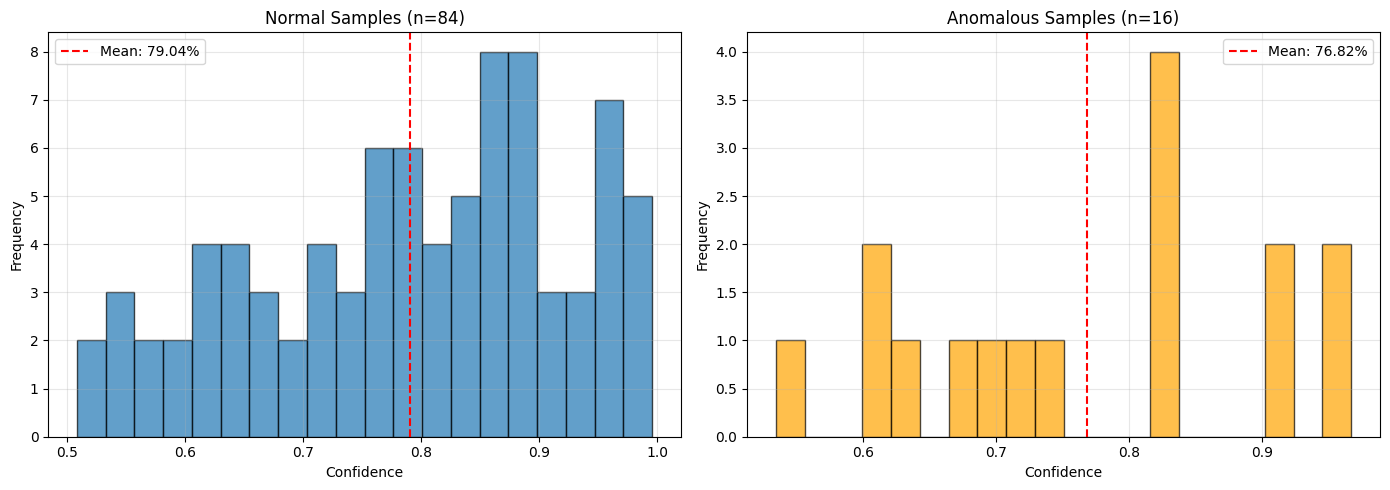


Accuracy by confidence level:
----------------------------------------
Confidence ≥50%: 78/100 = 78.00%
Confidence ≥60%: 74/91 = 81.32%
Confidence ≥70%: 61/74 = 82.43%
Confidence ≥80%: 43/51 = 84.31%
Confidence ≥90%: 19/21 = 90.48%


In [11]:
# ============================================
# VISUALIZE PREDICTION CONFIDENCE
# ============================================

def plot_prediction_confidence(detector, test_files, true_labels, sample_size=50):
    """
    Visualize prediction confidence distribution
    """
    import matplotlib.pyplot as plt

    # Get predictions
    if len(test_files) > sample_size:
        indices = np.random.choice(len(test_files), sample_size, replace=False)
        test_files_sample = [test_files[i] for i in indices]
        true_labels_sample = [true_labels[i] for i in indices]
    else:
        test_files_sample = test_files
        true_labels_sample = true_labels

    results = detector.predict_batch(test_files_sample, return_proba=True)

    # Separate by true label
    normal_confidences = []
    anomalous_confidences = []
    normal_correct = []
    anomalous_correct = []

    for result, true_label in zip(results, true_labels_sample):
        if result is None:
            continue

        is_correct = result['prediction'] == true_label

        if true_label == 0:  # Normal
            normal_confidences.append(result['confidence'])
            normal_correct.append(is_correct)
        else:  # Anomalous
            anomalous_confidences.append(result['confidence'])
            anomalous_correct.append(is_correct)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Normal samples
    axes[0].hist(normal_confidences, bins=20, alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(normal_confidences), color='red', linestyle='--',
                    label=f'Mean: {np.mean(normal_confidences):.2%}')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Normal Samples (n={len(normal_confidences)})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Anomalous samples
    axes[1].hist(anomalous_confidences, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axes[1].axvline(np.mean(anomalous_confidences), color='red', linestyle='--',
                    label=f'Mean: {np.mean(anomalous_confidences):.2%}')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Anomalous Samples (n={len(anomalous_confidences)})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print accuracy by confidence
    print("\nAccuracy by confidence level:")
    print("-" * 40)
    for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
        normal_above = sum(1 for c, corr in zip(normal_confidences, normal_correct)
                          if c >= threshold)
        normal_correct_above = sum(1 for c, corr in zip(normal_confidences, normal_correct)
                                  if c >= threshold and corr)

        anomalous_above = sum(1 for c, corr in zip(anomalous_confidences, anomalous_correct)
                              if c >= threshold)
        anomalous_correct_above = sum(1 for c, corr in zip(anomalous_confidences, anomalous_correct)
                                     if c >= threshold and corr)

        total_above = normal_above + anomalous_above
        total_correct_above = normal_correct_above + anomalous_correct_above

        if total_above > 0:
            acc = total_correct_above / total_above
            print(f"Confidence ≥{threshold:.0%}: {total_correct_above}/{total_above} = {acc:.2%}")

# Visualize confidence distribution
if 'detector' in globals() and len(paths_test) > 0:
    plot_prediction_confidence(detector, paths_test, y_test, sample_size=min(100, len(paths_test)))
else:
    print("Detector or test data not available.")
